In [1]:
from numpy import concatenate
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

In [2]:
#load the data
df = pd.read_csv("LSTM-Multivariate_pollution.csv")
display(df.head())

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


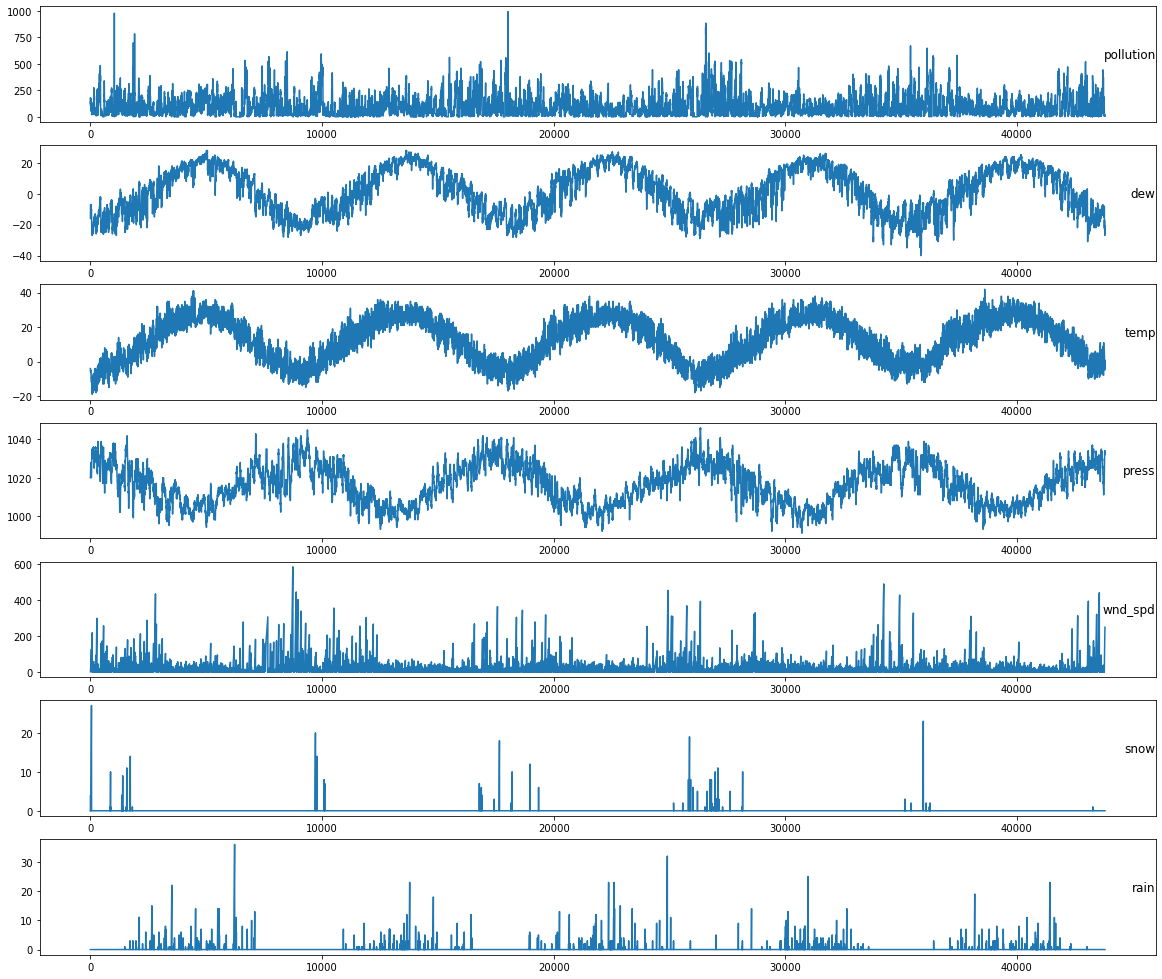

In [3]:
#Show the details of the data,no need to plot the wind direction
value = df.values
plt.figure(figsize=(20, 20))
for i in range(8):
    if i < 4:
        plt.subplot(8, 1, i+1)
        plt.plot(value[:, i+1])
        plt.title(df.columns[i+1], y=0.5, loc='right')
    if i > 4:
        plt.subplot(8, 1, i)
        plt.plot(value[:, i+1])
        plt.title(df.columns[i+1], y=0.5, loc='right')
plt.show()

In [4]:
# Check missing value and attribution type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [5]:
#Modifying data.
df1 = df.set_index('date')#Set the 'date' column as the index
df1['wnd_dir'] = df1['wnd_dir'].astype('category').cat.codes#Change the wind direction data type to category
df1.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


In [6]:
# Transfer series data to supervised data,the pollution1 is the y
values = df1.values
df2 = pd.DataFrame(values)
df3 = list()
df3.append(df2.shift(1))
df3.append(df2)
df4 = pd.concat(df3,axis=1)
df4.columns = ['pollution','dew','temp','press','wnd_dir','wnd_spd','snow','rain','pollution1','dew1','temp1','press1','wnd_dir1','wnd_spd1','snow1','rain1']
df4.dropna(inplace=True)
df4.drop(columns=['dew1','temp1','press1','wnd_dir1','wnd_spd1','snow1','rain1'], axis=1, inplace=True)
print(df4.head())

   pollution   dew  temp   press  wnd_dir  wnd_spd  snow  rain  pollution1
1      129.0 -16.0  -4.0  1020.0      2.0     1.79   0.0   0.0       148.0
2      148.0 -15.0  -4.0  1020.0      2.0     2.68   0.0   0.0       159.0
3      159.0 -11.0  -5.0  1021.0      2.0     3.57   0.0   0.0       181.0
4      181.0  -7.0  -5.0  1022.0      2.0     5.36   1.0   0.0       138.0
5      138.0  -7.0  -5.0  1022.0      2.0     6.25   2.0   0.0       109.0


In [7]:
# split into train and test sets
values = df4.values
#We select the first year data as our training data
train = values[:365 * 24, :]
test = values[365 * 24:, :]
trainX = train[:, :8]
trainy = train[:, 8]
testX = test[:, :8]
testy = test[:, 8]
# reshape
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [8]:
#Normalize the data
meanX = trainX.mean(axis=0)
meany = trainy.mean(axis=0)
stdX = trainX.std(axis=0)
stdy = trainy.std(axis=0)

norTrainX = (trainX-meanX)/stdX
norTestX = (testX-meanX)/stdX
norTrainy = (trainy-meany)/stdy
norTesty = (testy-meany)/stdy

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
69/69 - 1s - loss: 0.9166 - val_loss: 0.8432
Epoch 2/50
69/69 - 0s - loss: 0.7256 - val_loss: 0.6744
Epoch 3/50
69/69 - 0s - loss: 0.5445 - val_loss: 0.4960
Epoch 4/50
69/69 - 0s - loss: 0.3696 - val_loss: 0.3234
Epoch 5/50
69/69 - 0s - loss: 0.2282 - val_loss: 0.1946
Epoch 6/50
69/69 - 0s - loss: 0.1548 - val_loss: 0.1346
Epoch 7/50
69/69 - 0s - loss: 0.1314 - val_loss: 0.1082
Epoch 8/50
69/69 - 0s - loss: 0.1232 - val_loss: 0.0972
Epoch 9/50
69/69 - 0s - loss: 0.1199 - val_loss: 0.0927
Epoch 10/5

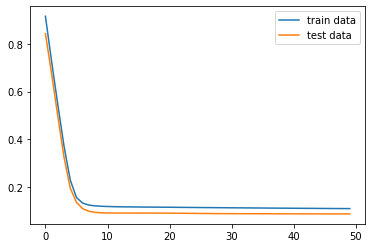

In [9]:
#Build and fit the network
model = Sequential()
model.add(LSTM(50, activation='relu',input_shape=(norTrainX.shape[1], norTrainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()
# fit the network
his = model.fit(norTrainX, norTrainy, epochs=50, batch_size=128, validation_data=(norTestX, norTesty), verbose=2, shuffle=False)
# plot the history
plt.plot(his.history['loss'], label='train data')
plt.plot(his.history['val_loss'], label='test data')
plt.legend()
plt.show()

In [10]:
# Prediction
ypr = model.predict(norTestX)
ypr = ypr*stdy + meany# Transfer back
# calculate RMSE
rmse = sqrt(mean_squared_error(testy, ypr))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 27.247


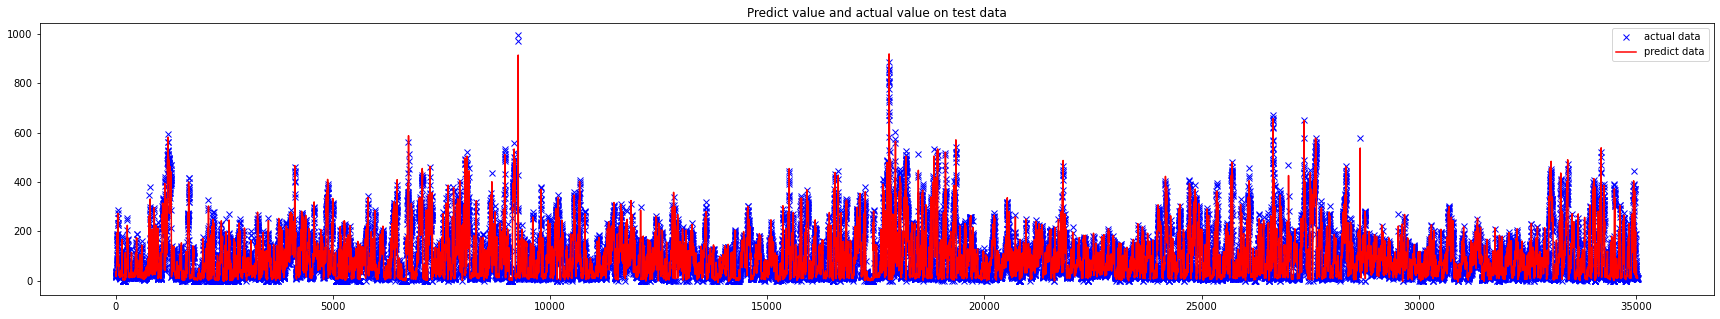

In [11]:
plt.figure(figsize=(30, 5))
plt.plot(range(testy.shape[0]),testy,'bx',label='actual data')
plt.plot(range(ypr.shape[0]),ypr,'r-',label='predict data')
plt.title("Predict value and actual value on test data")
plt.legend()
plt.show()

In [12]:
# Prediction
yprT = model.predict(norTrainX)
yprT = yprT*stdy + meany# Transfer back
# calculate RMSE
rmse = sqrt(mean_squared_error(trainy, yprT))
print('Train RMSE: %.3f' % rmse)

Train RMSE: 30.778


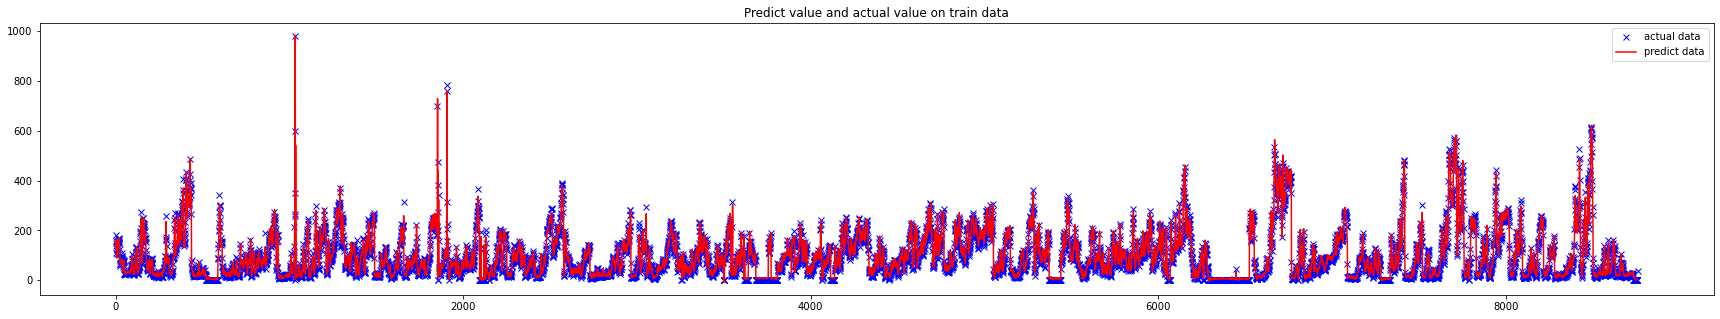

In [13]:
plt.figure(figsize=(30, 5))
plt.plot(range(trainy.shape[0]),trainy,'bx',label='actual data')
plt.plot(range(yprT.shape[0]),yprT,'r-',label='predict data')
plt.title("Predict value and actual value on train data")
plt.legend()
plt.show()